In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule
from sdofm.pretraining import MAE
from scripts.pretrain import Pretrainer
from lightning.pytorch.loggers.wandb import WandbLogger

In [3]:
sunspots_df = pd.read_csv('SN_d_tot_V2.0.csv', delimiter=';', header=None)

In [4]:
columns = ['year','month','day','date_fraction','sunspot_count','std_dev','observations','indicator']

In [5]:
sunspots_df.columns = columns   

In [6]:
import omegaconf

cfg = omegaconf.OmegaConf.load("../experiments/finetune_32.2M_mae_virtualeve.yaml")

In [7]:
data_module = SDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [8]:
#model = MAE(
#    **cfg.model.mae,
    #    **cfg.model.samae,
    #    hmi_mask=data_module.hmi_mask,
#    optimiser=cfg.model.opt.optimiser,
#    lr=cfg.model.opt.learning_rate,
#    weight_decay=cfg.model.opt.weight_decay,
    
#)

logger = WandbLogger(
    # WandbLogger params
    name=cfg.experiment.name,
    project=cfg.experiment.project,
    dir=cfg.experiment.wandb.output_directory,
    log_model=cfg.experiment.wandb.log_model,
    # kwargs for wandb.init
    tags=cfg.experiment.wandb.tags,
    notes=cfg.experiment.wandb.notes,
    group=cfg.experiment.wandb.group,
    save_code=True,
    job_type=cfg.experiment.wandb.job_type,

)
model = Pretrainer(cfg, logger=logger, is_backbone=True)


[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
Loading checkpoint...
Found pre-downloaded checkpoint at artifacts/model-tk45el88:v12/model.ckpt


/opt/conda/envs/sdofm/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.1


Checkpoint loaded from artifacts/model-tk45el88:v12/model.ckpt


In [9]:
val_dataset = data_module.valid_ds
train_dataset = data_module.train_ds

In [11]:
#model.model.to("cuda");
model.model.eval();

In [12]:
val_dataset.__len__(), train_dataset.__len__()

(43131, 450432)

In [13]:
import pandas as pd
dates = []
for i in range(train_dataset.__len__()):

    dates.append(train_dataset.aligndata.iloc[i].name)

dates_df = pd.DataFrame(dates, columns=["date"])

dates_df.reset_index(inplace=True, drop=False)

In [18]:
dates_df['year'] = pd.to_datetime(dates_df['date']).dt.year
dates_df['month'] = pd.to_datetime(dates_df['date']).dt.month
dates_df['day'] = pd.to_datetime(dates_df['date']).dt.day
dates_df['hour'] = pd.to_datetime(dates_df['date']).dt.hour
dates_df['time'] = pd.to_datetime(dates_df['date']).dt.time


In [19]:
dates_df

,index,date,year,month,day,hour,time
0,0,2010-05-13 00:00:00,2010,5,13,0,00:00:00
1,1,2010-05-13 00:12:00,2010,5,13,0,00:12:00
2,2,2010-05-13 00:24:00,2010,5,13,0,00:24:00
3,3,2010-05-13 00:36:00,2010,5,13,0,00:36:00
4,4,2010-05-13 00:48:00,2010,5,13,0,00:48:00
...,...,...,...,...,...,...,...
450427,450427,2023-08-02 22:00:00,2023,8,2,22,22:00:00
450428,450428,2023-08-02 22:12:00,2023,8,2,22,22:12:00
450429,450429,2023-08-02 22:24:00,2023,8,2,22,22:24:00
450430,450430,2023-08-02 22:36:00,2023,8,2,22,22:36:00


In [15]:
dates_df.shape

(450432, 6)

In [20]:
dates_with_spots_df = dates_df.merge(sunspots_df[['year','month','day','sunspot_count']], on=['year', 'month','day'], how='left')

In [21]:
import datetime
dates_with_spots_noon_df = dates_with_spots_df[dates_with_spots_df['time'] == datetime.time(12, 0)]
dates_with_spots_noon_2011_df = dates_with_spots_noon_df[dates_with_spots_noon_df['year'] == 2011]


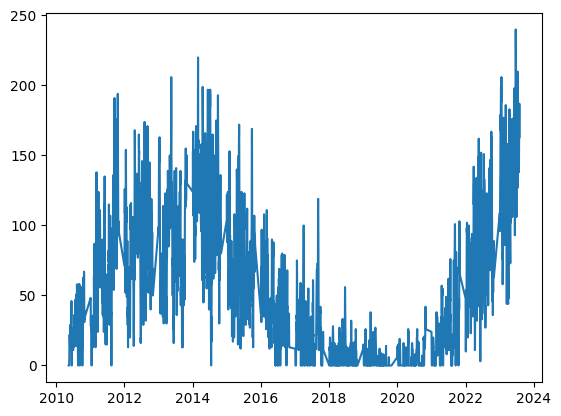

In [22]:
# plot the sunspot count vs date
import matplotlib.pyplot as plt
dates_with_spots_noon_2011_df = dates_with_spots_noon_df[dates_with_spots_noon_df['year'] == 2011]
plt.plot(dates_with_spots_noon_df['date'], dates_with_spots_noon_df['sunspot_count'])


In [23]:
df_2011 = dates_df[dates_df['year'] == 2011]
# groupby month, select 100 random samples
df_2011_subset = df_2011.groupby('month').apply(lambda x: x.sample(100, random_state=1)).reset_index(drop=True)
quiet_months = [1, 2, 5, 6, 7, 8]
df_2011_subset['is_active'] = df_2011_subset['month'].apply(lambda x: 0 if x in quiet_months else 1)

/var/tmp/ipykernel_7313/3167740649.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_2011_subset = df_2011.groupby('month').apply(lambda x: x.sample(100, random_state=1)).reset_index(drop=True)


In [24]:
cls_embeddings = []
mean_embeddings = []
names = []

for idx in tqdm(dates_with_spots_noon_2011_df['index'].values):
    batch = train_dataset[idx]
    name = train_dataset.aligndata.iloc[idx].name
    batch = torch.tensor(batch).unsqueeze(0)    
    #batch = batch.to("cuda")    
    x, mask, ids_restore = model.model.forward_encoder(batch, mask_ratio = 0)
    # cls_token 
    cls_embedding = x[:,0,:].detach().cpu()
    mean_embedding = x[:,1:,:].mean(dim=1).detach().cpu()
    cls_embeddings.append(cls_embedding)
    mean_embeddings.append(mean_embedding)
    names.append(name)
cls_embeddings = torch.cat(cls_embeddings, dim=0)
mean_embeddings = torch.cat(mean_embeddings, dim=0)

  4%|▎         | 10/267 [00:26<11:29,  2.68s/it]

num_samples = 5000
cls_embeddings = []
mean_embeddings = []
names = []
for i in tqdm(range(num_samples)):
    batch = val_dataset[i]
    name = val_dataset.aligndata.iloc[i].name
    batch = torch.tensor(batch).unsqueeze(0)    
    batch = batch.to("cuda")    
    x, mask, ids_restore = model.model.forward_encoder(batch, mask_ratio = 0)
    # cls_token 
    cls_embedding = x[:,0,:].detach().cpu()
    mean_embedding = x[:,1:,:].mean(dim=1).detach().cpu()
    cls_embeddings.append(cls_embedding)
    mean_embeddings.append(mean_embedding)
    names.append(name)
cls_embeddings = torch.cat(cls_embeddings, dim=0)
mean_embeddings = torch.cat(mean_embeddings, dim=0)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:

tsne = TSNE(n_components=2, random_state=0)

cls_embeddings_np = cls_embeddings.numpy()
cls_embeddings_tsne = tsne.fit_transform(cls_embeddings_np)



dates_with_spots_noon_2011_df['cls_tsne_x'] = cls_embeddings_tsne[:,0]
dates_with_spots_noon_2011_df['cls_tsne_y'] = cls_embeddings_tsne[:,1]


tsne = TSNE(n_components=2, random_state=0)

mean_embeddings_np = mean_embeddings.numpy()
mean_embeddings_tsne = tsne.fit_transform(mean_embeddings_np)



dates_with_spots_noon_2011_df['avg_tsne_x'] = mean_embeddings_tsne[:,0]
dates_with_spots_noon_2011_df['avg_tsne_y'] = mean_embeddings_tsne[:,1]



In [ ]:

fig = px.scatter(dates_with_spots_noon_2011_df, x="cls_tsne_x", y="cls_tsne_y", color="is_active", hover_data=["month", "day", "hour"])

fig.show()


In [ ]:
fig = px.scatter(dates_with_spots_noon_2011_df, x="avg_tsne_x", y="avg_tsne_y", color="is_active", hover_data=["month", "day", "hour"])

fig.show()


In [ ]:
# save html
fig.write_html("mean_pooling_tsne.html")


In [ ]:
#!pip install plotly